In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

In [215]:
def honestBlocksBernoulli(a_, b_, g_, p_, C_, E_):
    expr1 = (1-a_)/(a_*p_*(1-np.min([1,np.exp(-b_+C_+E_)]))+a_*(1-p_)*(1-np.exp(-b_+C_)))
    expr2 = expr1 + (2*(1-a_)*(1-g_)+g_*(1-a_))*(1-a_) + a_*(1-a_)
    return expr2

def attackBlocksBernoulli(a_, b_, g_, p_, C_, E_):
    num   = a_*p_*np.min([1,np.exp(-b_+C_+E_)])+a_*(1-p_)*np.exp(-b_+C_)
    den   = a_*p_*(1-np.min([1,np.exp(-b_+C_+E_)]))+a_*(1-p_)*(1-np.exp(-b_+C_))
    expr1 = num / den
    expr2 = (a_**3) / ((1-2*a_)*(1-a_))
    expr3 = expr1 + (2*a_ + g_*(1-a_))*(1-a_) + a_**2 + a_*(2-a_)/(1-a_) + expr2
    return expr3

def fixRewTheo(a_, b_, g_, p_, C_, E_):
    A = attackBlocksBernoulli(a_, b_, g_, p_, C_, E_)
    H = honestBlocksBernoulli(a_, b_, g_, p_, C_, E_)
    return A/(A+H)

In [71]:
theoRes = []
for a in alphas:
    temp1 = []
    for b in betas:
        temp2 = []
        for p in ps:
#             temp2.append(attackBlocksBernoulli(a=a, b=b, g=0.0, p=p, E=1., C=1.))
            temp2.append(fixRewTheo(a=a, b=b, g=0.0, p=p, E=1., C=1.))
        temp1.append(temp2)
    theoRes.append(temp1)
theoRes = np.array(theoRes)
theoRes.shape

(5, 225, 3)

In [163]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, C, E  = sp.symbols('a b x g p C E')

In [186]:
# ps should be the same
p0    = p1 / (a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1)))
p0p   = p1 * (1-a)
p0pp  = p1 * a
p2    = p1*(a/(1-a))
prest = p1*a/(1-2*a)

In [187]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

In [189]:
p1_me = (1/(a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1))) + 1 + (1-a)/(1-2*a))**(-1)
p1_me

1/(1 + 1/(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + (1 - a)/(1 - 2*a))

In [192]:
p1_sym.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1}), p1_me.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1})

(0.138811963706275, 0.138811963706275)

In [193]:
f0i   = C * (a*p*sp.Min(1,sp.exp(-b+C+E)) + a*(1-p)*sp.exp(-b+C))
f0ii  = a*C * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-sp.exp(-b+C)))
f0iii = (1-a)*(a+g*(1-a))*C * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-sp.exp(-b+C)))
f0iii

C*(1 - a)*(a + g*(1 - a))*(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b)))

In [194]:
f0   = f0i + f0ii + f0iii
f1   = C*(a+(1-a)*a)

In [169]:
# DONT NEED
f1   = a + a*(1-a)
f2   = a + a*(1-a)
f3   = a + a*(1-a) + a*(1-a)**2
f4   = a + a*(1-a) + a*(1-a)**2 + a*(1-a)**3

In [203]:
full  = p0*f0 + p1*f1 + C*p1*a*(2*a*(1-a)/(1-2*a))
p1_ev = p1_sym.evalf(subs={C:1., E:1.})
final = sp.simplify(full.evalf(subs={p1:p1_ev, C:1., E:1., g:0}))
final

a*(0.245252960780962*a**2*(a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 0.122626480390481*a*(a - 2.0)*(2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 0.122626480390481*(2.0*a - 1.0)*(1.0*a*(a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 1.0*a*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) + 1.0*p*exp(b)*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p + 2.71828182845905))*(-5.43656365691809*a*p + 5.43656365691809*a + 2.71828182845905*p + (2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 2.0*a - p*Min(1.0, 7.38905609893065*exp(-b)) + 1.0)*exp(b) - 2.71828182845905)/((2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905))*(-a**2*p + a**2 + 0.666666666666667*a*p - 0.666666666666667*a + 0.1226

In [204]:
finalLambda = sp.lambdify((a, b, p), final)
finalLambda

<function _lambdifygenerated(a, b, p)>

In [206]:
g0   = C*(1-a)
g1   = C*(1-a)*(1-a)*(1-g)
g0p  = C*(1-a)
g0pp = C*(1-a)

In [207]:
gull = p0*g0 + p1*g1 + p0p*g0p + p0pp*g0pp
ginal = gull.evalf(subs={p1:p1_ev, C:1., E:1., g:0})
ginal

1.0*a**2*(1.0 - a)*(-2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 5.43656365691809*a*p*exp(-b) + 2.0*a - 5.43656365691809*a*exp(-b) + p*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p*exp(-b) - 1.0 + 2.71828182845905*exp(-b))/(-3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) + 8.15484548537714*a**2*p*exp(-b) + 3.0*a**2 - 8.15484548537714*a**2*exp(-b) + 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 5.43656365691809*a*p*exp(-b) + 5.43656365691809*a*exp(-b) - 1.0) + 2.0*a*(1.0 - a)**2*(-2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 5.43656365691809*a*p*exp(-b) + 2.0*a - 5.43656365691809*a*exp(-b) + p*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p*exp(-b) - 1.0 + 2.71828182845905*exp(-b))/(-3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) + 8.15484548537714*a**2*p*exp(-b) + 3.0*a**2 - 8.15484548537714*a**2*exp(-b) + 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 5.43656365691809*a*p*exp(-b) + 5.43656365691809*a*exp(-b) - 1.0) + 1.0*a*(1.0 - a)*(-2.0*a*p*Min(1.0, 7.38905609893065*ex

In [208]:
ginalLambda = sp.lambdify((a, b, p), ginal)
ginalLambda

<function _lambdifygenerated(a, b, p)>

In [209]:
alphas    = [0.2, 0.25, 0.3, 0.35, 0.4]
betas     = np.arange(1.751, 4, 0.01)
ps        = [0.25, 0.5, 0.75] # using E=1, C=1
newbs     = np.arange(1.751, 4, 0.1)
newbs

array([1.751, 1.851, 1.951, 2.051, 2.151, 2.251, 2.351, 2.451, 2.551,
       2.651, 2.751, 2.851, 2.951, 3.051, 3.151, 3.251, 3.351, 3.451,
       3.551, 3.651, 3.751, 3.851, 3.951])

In [210]:
test  = finalLambda(a=0.3, b=1, p=0.5)
test2 = ginalLambda(a=0.3, b=1, p=0.5)
test+test2

2.568181818181816

In [211]:
newRes = []
for a_ in alphas:
    temp1 = []
    for b_ in newbs:
        temp2 = []
        for p_ in ps:
            attack = finalLambda(a=a_, b=b_, p=p_)
            honest = ginalLambda(a=a_, b=b_, p=p_)
            temp2.append(attack/(attack+honest))
        temp1.append(temp2)
    newRes.append(temp1)
newRes = np.array(newRes)
newRes.shape

(5, 23, 3)

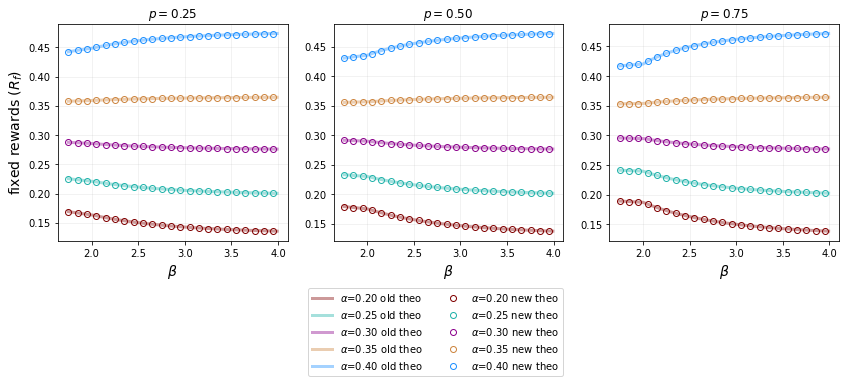

In [222]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

colors = ['maroon', 'lightseagreen', 'darkmagenta', 'peru', 'dodgerblue'] 
handles, labels = [], []

for i in range(3):
    ax = axarr[i]
    for j, a_ in enumerate(alphas):
        line, = ax.plot(betas, theoRes[j,:,i], linewidth=3, color=colors[j], alpha=0.4,
                        label=r'$\alpha$={:0.2f} old theo'.format(a_))
        if i == 0:
            handles.append(line)
            labels.append(r'$\alpha$={:0.2f} old theo'.format(a_))

for i in range(3):
    ax = axarr[i]
    for j, a_ in enumerate(alphas):
        marker, = ax.plot(newbs, newRes[j,:,i], marker='o', color=colors[j], linestyle='none', 
                          fillstyle='none', label=r'$\alpha$={:0.2f} new theo'.format(a_))
        if i == 0:
            handles.append(marker)
            labels.append(r'$\alpha$={:0.2f} new theo'.format(a_))


for i, ax in enumerate(axarr):
    ax.grid(alpha=0.2)
    ax.set_xlabel(r'$\beta$', size=14)
    ax.set_title(r'$p=${:0.2f}'.format(ps[i]))

axarr[0].set_ylabel(r'fixed rewards ($R_f)$', size=14)
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=2)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [219]:
def NEW(a_, b_, p_):
    attack = finalLambda(a=a_, b=b_, p=p_)
    honest = ginalLambda(a=a_, b=b_, p=p_)
    return attack/(attack+honest)

def OLD(a_, b_, p_):
    return fixRewTheo(a_=a_, b_=b_, g_=0.0, p_=p_, E_=1., C_=1.)

In [221]:
NEW(0.3, 2., 0.5) - OLD(0.3, 2., 0.5)

1.1102230246251565e-16